# Exploratory Data Analysis

In [2]:
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import itertools

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data
adni_df = pd.read_csv('../../data/Merge/ADNIMERGE.csv')

## Description of Data

### Description of ADNI Merge

The ADNI study is made up of four distinct phases – ADNI1, ADNIGO, ADNI2, and ADNI3 – in each of which new participants were recruited while existing participants from earlier phases continued to be monitored. Our main dataset is the ADNI Merge dataset, from the [Alzheimer's Disease Neuroimaging Initiative](http://adni.loni.usc.edu/).  This is essentially a dataset combining key predictors from all four phases, assembled using various sources of data within the ADNI repository. A high-level overview of the categories is as follows: 

1. **Cognitive Tests**: some of the predictors, such as MMSE (Mini-Mental State Examination), CDRSB (Clinical Dementia Rating Sum of Boxes), ADAS (Alzheimer’s Disease Assessment Scale–Cognitive subscale) and RAVLT (Rey Auditory Verbal Learning Test) come from cognitive tests that clinicians used to base the patient diagnoses on.
2. **Demographic Variables**: such as Age, Gender, Marriage status and Education levels. 
4. **Brain-Related Variables**: these variables, such as Hippocampus, Ventricles, WholeBrain, Entorhinal, Fusiform and MidTemp) measure various aspects of the brain.
3. **Important Biomarkers**: biomarkers, such as A-beta (Amyloid Beta), Tau, APOE4 and FDG, are important proteins or biomarkers that are associated with Alzheimer’s disease or Mild Cognitive Impairment in a lot of medical literature about the disease.

The table below provides a more detailed overview of the key variables present in our dataset, the range of values that these variables take on and the percentage of missing values, which is a key component to take into consideration with this dataset.

![png](eda_files/tests.png "Tests")

![png](eda_files/medical.png "Medical")

### Missing Values

Given the strict data-collection protocol followed and strict criteria for selecting patients so as to prevent drop-out, we expect that missing values are typically Missing At Random (MAR); missingness is due solely to observable factors such as the follow-up time (i.e. not all variables are re-collected at every follow-up), the patient’s initial diagnosis, and the particular ADNI phase (given that the data are currently in longform). Especially where the missingness is due to differing procedures carried out for patients with different baseline diagnoses, we must ensure that the way we handle missing values does not introduce bias in our model. 

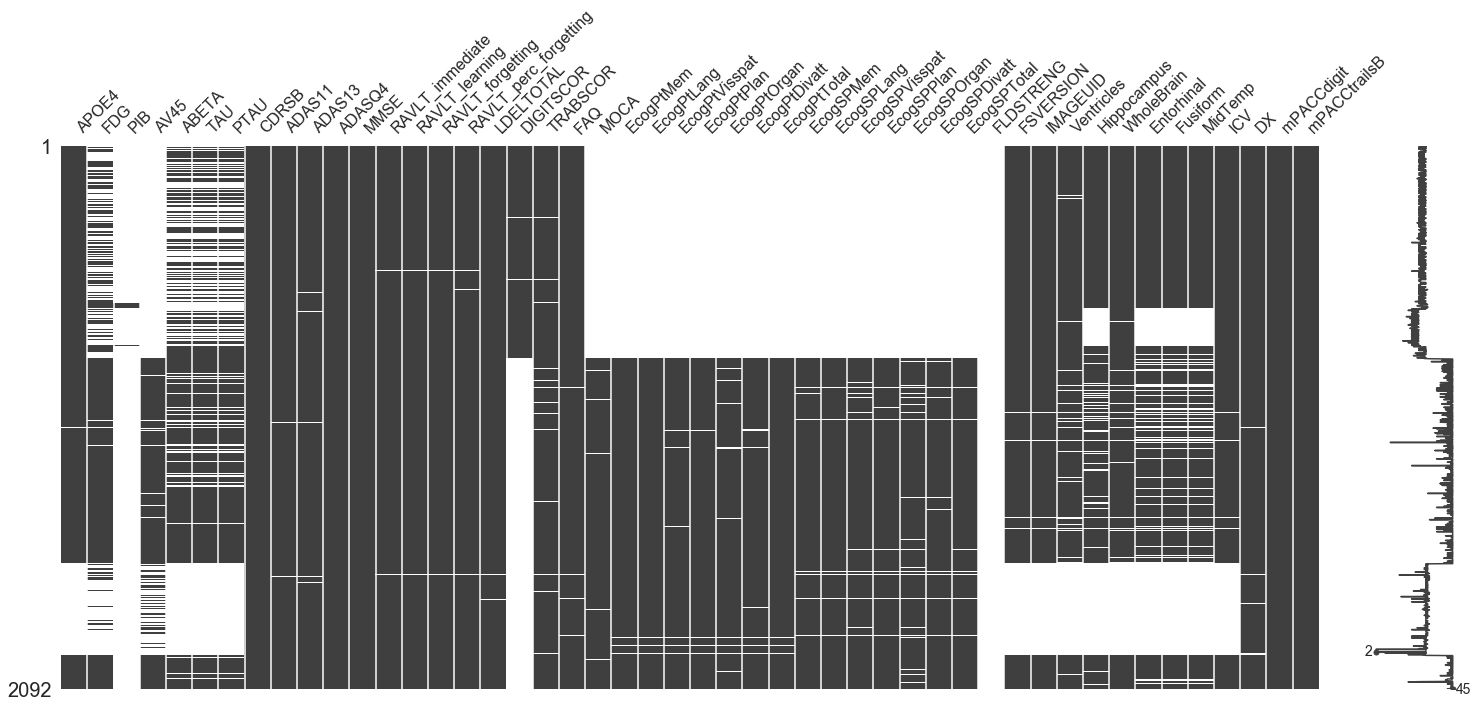

In [5]:
import missingno as msno

# remove baseline variables
adni_df_missingness = adni_df[[col for col in adni_df.columns if col[-3:] != "_bl"]]

# plot missing values for baseline observations, sorted by protocol (i.e. ADNI stage)
keep_cols = list(adni_df_missingness.columns[adni_df_missingness.isna().sum() > 10]) + ['VISCODE','COLPROT']
adni_anymissing = adni_df_missingness.loc[adni_df_missingness.VISCODE == 'bl',keep_cols].sort_values(['VISCODE','COLPROT'])
msno.matrix(adni_anymissing.loc[:, (adni_anymissing.columns != 'VISCODE') & (adni_anymissing.columns != 'COLPROT')])
a = 2

The plot above shows that certain categories, such as the Everyday Cognition (Ecog) are missing in general for the ADNI 1 phase, whereas the brain related predictors are missing for ADNI 3. One important observation is that the important biolarkers (such as Amyloid Beta, Tau and PTau) are missing partially throughout the data. The reason for this is that these are taken from a patient's Cerebraospinal Fluid ([CSF](https://medlineplus.gov/ency/article/003428.htm)), which requires an invasive procedure to obtain. Therefore, not all patients undergo this procedure during a baseline test and we see a lot of missing values here.

## Demographic Information

The patient demographics helped shape some of our goals and research questions. First, we noticed that all participants were at or above the age of 55. This means that our ability to make an "early" diagnosis is limited, since many of the participants got a screening done since they exhibited symptoms of cognitive impairment of some form. Second, we notice that a majority of our population is white and married. We understand that this means that our findings do not extend to a larger population.

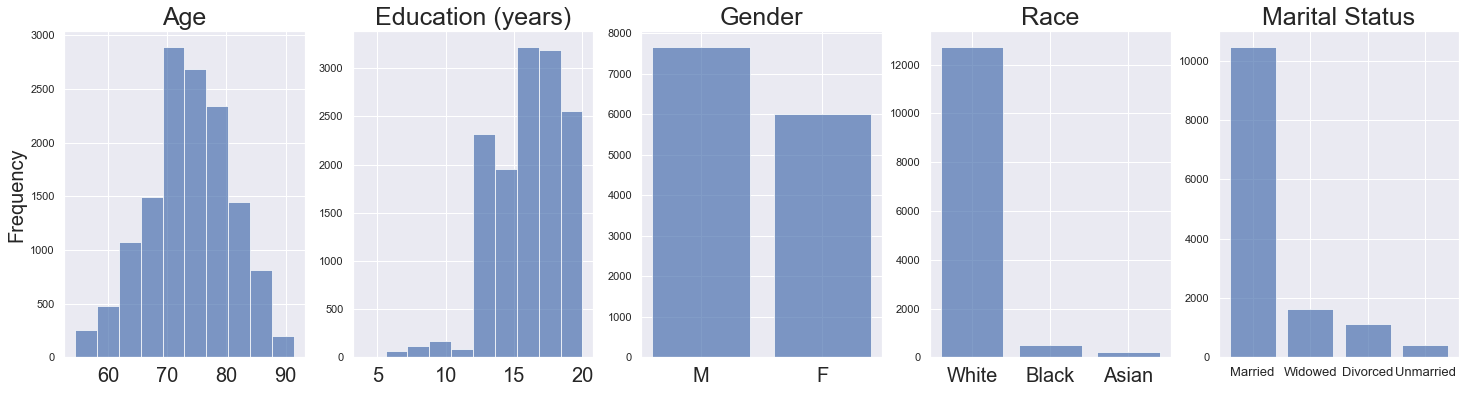

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,6))
axes = ax.ravel()
fields = ['AGE', 'PTEDUCAT', 'PTGENDER', 'PTETHCAT', 'PTMARRY']

# AGE
visits = adni_df['AGE'].dropna(axis=0)
axes[0].hist(visits, bins=10, alpha=0.7)
ax[0].set_title('Age',fontsize=25)
ax[0].set_ylabel('Frequency',fontsize=20)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

# EDUCATION
visits = adni_df['PTEDUCAT'].dropna(axis=0)
axes[1].hist(visits, bins=10, alpha=0.7)
ax[1].set_title('Education (years)',fontsize=25)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

# GENDER
visits = adni_df['PTGENDER'].dropna(axis=0)
names = [val[0] for val in visits.value_counts().index.values]
heights = visits.value_counts().values
ax[2].bar(names, heights, alpha=0.7)
ax[2].set_title('Gender',fontsize=25)
for tick in ax[2].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

# RACE
visits = adni_df['PTRACCAT'].dropna(axis=0)
names = visits.value_counts().index.values[0:3]
heights = visits.value_counts().values[0:3]
ax[3].bar(names, heights, alpha=0.7)
ax[3].set_title('Race',fontsize=25)
for tick in ax[3].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

# MARITAL STATUS
visits = adni_df['PTMARRY'].dropna(axis=0)
names = ['Married', 'Widowed', 'Divorced', 'Unmarried']
heights = visits.value_counts().values[0:4]
ax[4].bar(names, heights, alpha=0.7)
ax[4].set_title('Marital Status',fontsize=25)
for tick in ax[4].xaxis.get_major_ticks():
    tick.label.set_fontsize(13) 

## Initial Diagnoses

The baseline diagnoses are encoded in two ways in the ADNI Merge Dataset. The first encoding is as follows: 

1. CN: Cognitively Normal
2. MCI: Mild Cognitive Impairment
3. Dementia: Alzheimer's Disease or other Dementia. 

The second encoding is as follows: 

1. CN: Cognitively Normal
2. EMCI: Early Mild Cognitive Impairment
3. LMCI: Late Mild Cognitive Impairment
4. SMC: Significant Memory Concerns
5. AD: Alzheimer's Disease

We choose the first encoding, changing 'Dementia' to 'AD' since there is an equivalency in the encoding of these categories. The second encoding is present only in the baseline diagnoses and not in the subsequent diagnoses, and part of our modeling is to predict future decline, so we choose the first encoding to remain consistent between diagnoses at different points of time.

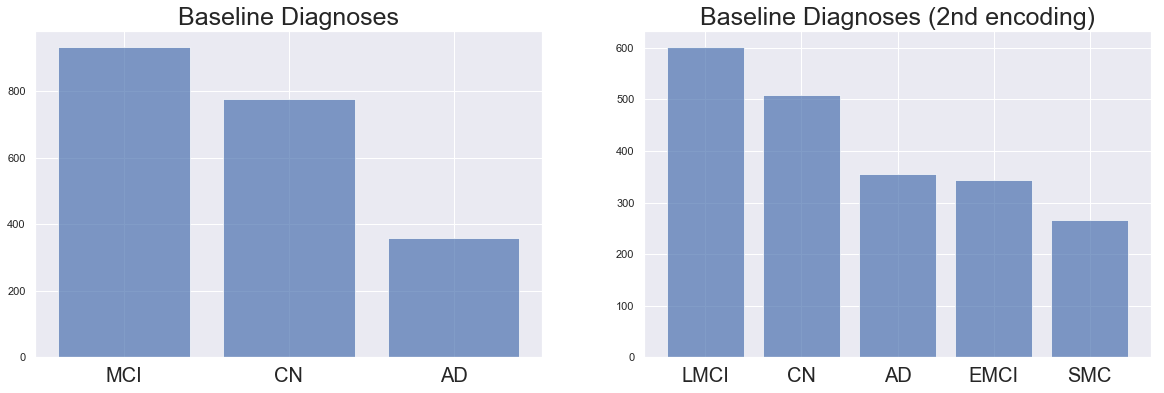

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes = ax.ravel()
sub_df = adni_df[adni_df['M'] == 0]

# DX
dxs = sub_df['DX'].map({'Dementia': 'AD', 'CN': 'CN', 'MCI': 'MCI'})
names =  dxs.value_counts().index.values
heights = dxs.value_counts().values
axes[0].bar(names, heights, alpha=0.7)
axes[0].set_title('Baseline Diagnoses', fontsize=25)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
# DX_bl
dxs = sub_df['DX_bl']
names =  dxs.value_counts().index.values
heights = dxs.value_counts().values
axes[1].bar(names, heights, alpha=0.7)
axes[1].set_title('Baseline Diagnoses (2nd encoding)', fontsize=25)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

### Important Predictors for Initial Diagnosis

From a histogram of baseline values for all predictors in our dataset conditional on initial diagnosis, a few predictors stood out to us, as being promising indicators of baseline diagnosis. These pertained to examination scores, which doctors heavily rely on to make their initial diagnoses. This influenced our decision to explore one such heavily influential examination, the MMSE (Mini-Mental State Examination) in particular. 

The histograms below correspond to four cognitive tests that show a promising separability between the three classes at baseline levels. We further explore these four cognitive tests and three tests from the ADAS (Alzheimer's Disease Assessment Scale) test in a pair plot that also shows promise in a combination of cognitive tests being used to predict initial diagnoses.

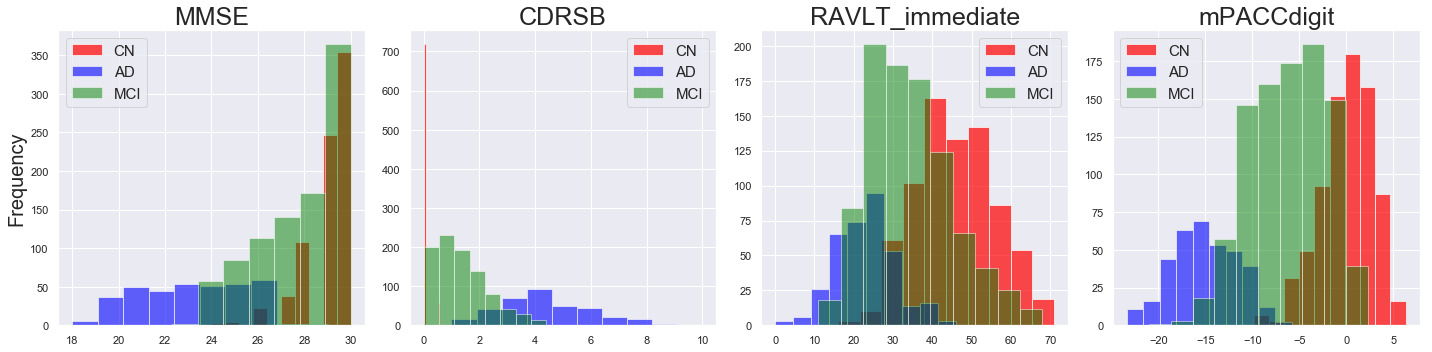

In [6]:
color_dict = {'CN': 'red', 'AD': 'blue', 'Dementia': 'blue', 'LMCI': 'green', 'MCI': 'green', 'EMCI': 'orange',
             'SMC': 'purple'}
name_dict = {'CN': 'CN', 'Dementia': 'AD', 'MCI': 'MCI'}
baseline_df = adni_df[adni_df['M'] == 0]
variables = ['MMSE', 'CDRSB', 'RAVLT_immediate', 'mPACCdigit']
row = math.ceil(len(variables)/4)
col = min(4,len(variables))
fig, ax = plt.subplots(figsize=(5*col,5*row), nrows=row, ncols=col)
axes = ax.ravel()
for i, var in enumerate(variables):
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=20)
    time = 'M'
    diag = 'DX'
    df_copy = baseline_df[[time,diag,var]].copy().dropna(axis=0)
    dxs = df_copy[diag].unique()
    for c, dx in enumerate(dxs):
        df_inb = df_copy[df_copy[diag] == dx]
        color = color_dict[dx]
        axes[i].hist(df_inb[var], color=color, label=name_dict[dx], alpha=(0.7-0.1*c))
    axes[i].set_title(var, fontsize=25)
    axes[i].legend(fontsize=15)
fig.tight_layout()

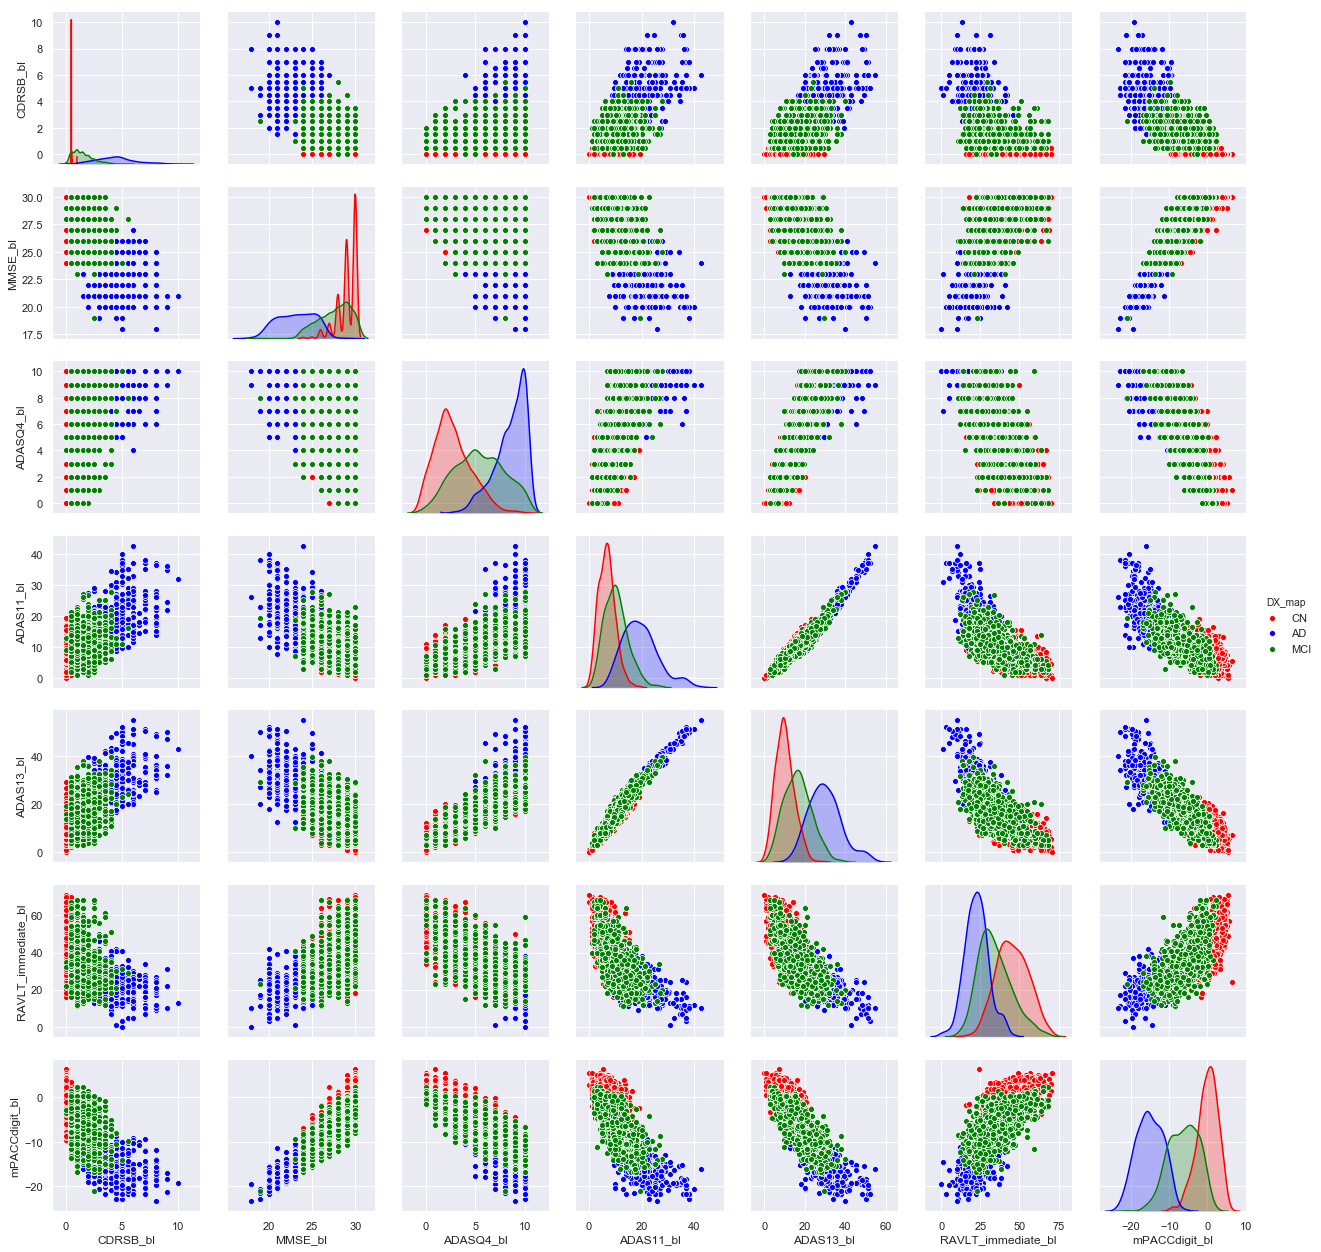

In [7]:
cols = ['DX']
baseline_df = adni_df[adni_df['M'] == 0]
baseline_df['DX_map'] = baseline_df['DX'].map(name_dict)
for col in baseline_df.columns.values:
    if '_bl' in col:
        cols.append(col)
cols = ['CDRSB_bl', 'MMSE_bl', 'ADASQ4_bl', 'ADAS11_bl', 'ADAS13_bl', 'RAVLT_immediate_bl', 'mPACCdigit_bl']
sns.pairplot(baseline_df, vars=cols, hue="DX_map", height=2.5, diag_kind='kde', 
             palette={'CN': 'red', 'MCI': 'green', 'AD': 'blue'})

## Diagnoses Over Time

In addition to being able to predict initial diagnosis, we also aim to predict future decline i.e. patients who were initially diagnosed as Cognitively Normal and later were diagnosed with Mild Cognitive Impairment, or patients who were initially diagnosed with Mild Cognitive Impairment and later became diagnosed with Alzheimer's Disease. In order to do this, we have a few different visuals to get a sense of the distribution of diagnoses over time and how MMSE scores (an important determiner of diagnosis) vary over time for patients. 

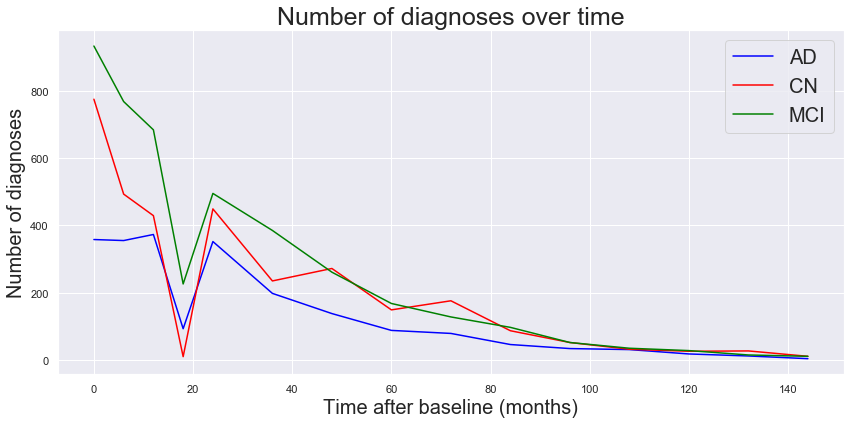

In [8]:
kde_df = adni_df[['RID', 'M', 'DX']]
dicts = []
kde_df['DX'] = kde_df['DX'].map(name_dict)
for m in sorted(kde_df['M'].unique()):
    df = kde_df[kde_df['M'] == m]
    dict_c = {'M': m}
    if len(df['DX'].value_counts()) > 2:
        dict_c.update(dict(df['DX'].value_counts()))
        dicts.append(dict_c)
table_df = pd.DataFrame(dicts)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(table_df['M'], table_df['AD'], c='blue', label='AD')
ax.plot(table_df['M'], table_df['CN'], c='red', label='CN')
ax.plot(table_df['M'], table_df['MCI'], c='green', label='MCI')
ax.set_title('Number of diagnoses over time', fontsize=25)
ax.set_ylabel('Number of diagnoses', fontsize=20)
ax.set_xlabel('Time after baseline (months)', fontsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

We observe that the total number of diagnoses of each kind drops over time, which may perhaps be a result of patients not carrying out a follow up study for a number of different reasons. 

### MMSE scores over time 

Next, we show how MMSE scores vary over time for participants. We plot trajectories of MMSE scores for each of the three diagnosis types. We anticipate there to be a gradual decline in MMSE scores for the AD and MCI categories and perhaps a smaller decline for the CN category but this plot helps discern between the different groups based on rate of dropoff of MMSE scores.

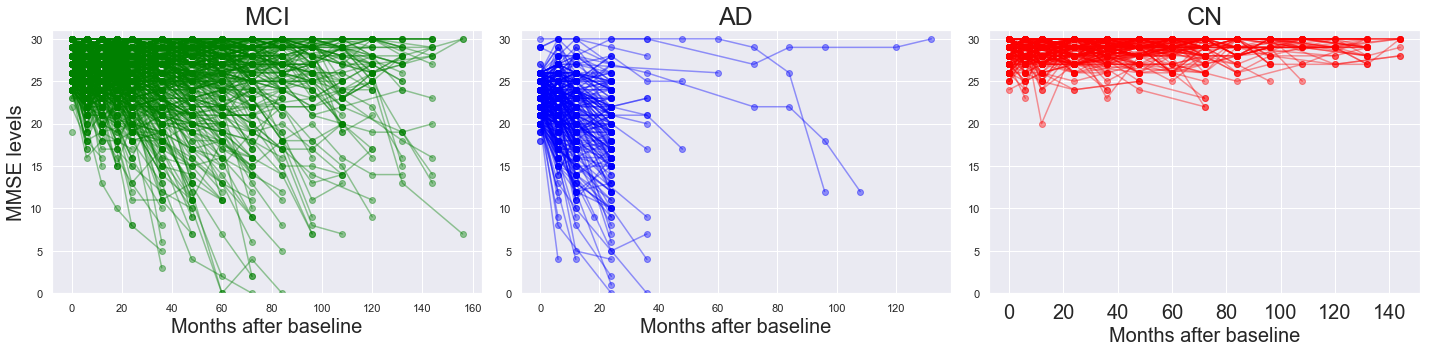

In [9]:
traj_df = adni_df[['RID', 'M', 'MMSE', 'DX_bl', 'DX']].dropna(axis=0)
traj_df = traj_df.groupby('RID').aggregate({'M': lambda x: list(x), 'MMSE': lambda x: list(x), 'DX_bl': 'max',
                                           'DX': 'max'})
diags = traj_df['DX'].unique()

fig, ax = plt.subplots(ncols=len(diags), nrows=1, figsize=(20,5))
axes = ax.ravel()

for i,dx in enumerate(diags):
    if i == 0:
        axes[i].set_ylabel('MMSE levels', fontsize=20)
    for diag, vals, mths in traj_df[traj_df['DX'] == dx][['DX', 'MMSE', 'M']].values:
        sort_mths = [mth for mth,val in sorted(zip(mths,vals))]
        sort_vals = [val for mth,val in sorted(zip(mths,vals))]
        axes[i].plot(sort_mths, sort_vals, 'o-', alpha=0.4, color=color_dict[dx])
    axes[i].set_title(name_dict[dx], fontsize=25)
    axes[i].set_xlabel('Months after baseline', fontsize=20)
    axes[i].set_ylim((0,31))
for tick in axes[i].xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
fig.tight_layout()

As hypothesized, the dropoff of MMSE scores for the MCI group is faster and larger than that for the CN group. It is striking to observe that many patients initially diagnosed with AD have no observations after 3 years. 

### Change in Diagnosis Between First Visit and Most Recent Visit

Using our plots above, we turn to the question of predicting change in diagnoses between first and most recent visit for a particular patient. We subset our dataset to include only patients who have multiple observations and show the number of diagnoses of each kind at baseline and at patients' most recent visit. One extremely important caveat is that the most recent visit can be 2 years later or 12 years later, and the time between first and last visit is an extremely important predictor that we keep in mind when modeling.

In [10]:
df = adni_df.copy()
indexes_last_visit=[]
for patient_ids in df.PTID.unique():
    latest_visit_M=df[df.PTID==patient_ids]['M'].max()
    d=df[ df.PTID==patient_ids ]['M']== latest_visit_M
    ind=d.index[-1]
    indexes_last_visit.append(ind);

# Only last visits
df_last=df.loc[indexes_last_visit]

df_dx = adni_df[adni_df['M'] == 0]
df_dx['DX0'] = df_dx['DX']
df_last_imp = df_last[['RID','DX']]
df_dx = df_dx[['RID', 'DX']]
df_dx = df_dx.merge(df_last_imp, how='left', on='RID')
df_dx = df_dx.dropna(axis=0) 
print(df_dx.shape)

(1648, 3)


In [11]:
df_dx['DX_x'] = df_dx['DX_x'].map(name_dict)
df_dx['DX_y'] = df_dx['DX_y'].map(name_dict)
df_dx['DX_x'].value_counts()
df_dx['DX_y'].value_counts()
df_dx['transition'] = df_dx['DX_x'] + ',' + df_dx['DX_y']

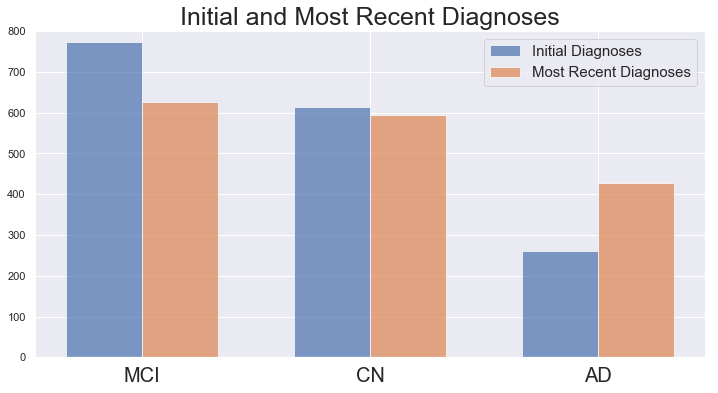

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
sub_df = df_dx

dxs = sub_df['DX_x']
names_init =  dxs.value_counts().index.values
heights_init = dxs.value_counts().values

dxs = sub_df['DX_y']
names_fin =  dxs.value_counts().index.values
heights_fin = dxs.value_counts().values

ax.bar([0,1.5,3], heights_init, width=0.5, alpha=0.7, label='Initial Diagnoses')
ax.bar([0.5,2,3.5], heights_fin, width=0.5, alpha=0.7, label='Most Recent Diagnoses')
ax.set_title('Initial and Most Recent Diagnoses', fontsize=25)
ax.set_xticks([0.25, 1.75, 3.25])
ax.set_xticklabels(['MCI', 'CN', 'AD'])
ax.legend(fontsize=15)
ax.set_ylim(0,800)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

A general pattern seems to be that the total number of MCI and CN diagnoses has decreased while the number of AD diagnoses has increased over time, which is unsurprising.

We create a table, with each entry representing a participant's initial and most recent diagnoses. A majority of participants start and end with the same diagnoses, however a subset of participants do decline, especially from MCI to AD. A non-trivial number of participants move from MCI to CN, which is worth noting. Of the 1648 participants with multiple observations, only 204 decline, which is about **12.3%** of our total sample. This is an important finding that suggests that we should perform classification with balanced class weights in our modeling phase. 

The Sankey Diagram below illustrates changes in diagnoses and highlights some major trends: that a majority of patients have the same initial and most recent diagnoses.

In [13]:
outcomes = df_dx['transition'].value_counts()
outcomes = outcomes.to_dict()

# Creating tuples of the form (source, destination, value) in order to play nice with plotly

k1_dict = {'CN': 0, 'MCI': 1, 'AD': 2}
k2_dict = {'CN': 3, 'MCI': 4, 'AD': 5}
tuples = []
tables = np.zeros(shape=(3,3))
for k in outcomes:
    v = outcomes[k]
    k1, k2 = k.split(',')
    tuples.append(tuple([k1_dict[k1], k2_dict[k2], v]))
    tables[k1_dict[k1]][k1_dict[k2]] = v
# print(tuples)
table_changes = pd.DataFrame(tables, columns=['End CN', 'End MCI', 'End AD'])
table_changes['DX'] = ['Start CN', 'Start MCI', 'Start AD']
columns = table_changes.columns.tolist()
columns = columns[-1:] + columns[:-1]
table_changes = table_changes[columns] 
table_changes

,DX,End CN,End MCI,End AD
0,Start CN,555.0,48.0,12.0
1,Start MCI,39.0,578.0,156.0
2,Start AD,0.0,1.0,259.0


![png](eda_files/sankey.png "Sankey")

In [14]:
# data = dict(
#     type='sankey',
#     node = dict(
#       pad = 55,
#       thickness = 10,
#       line = dict(
#         color = "black",
#         width = 0.5
#       ),
#       label = ["CN", "MCI", "AD"]*3,
#       color = ["red", "green", "blue"]*3
#     ),
#     link = dict(
#       source = list(list(zip(*tuples))[0]),
#       target = list(list(zip(*tuples))[1]),
#       value = list(list(zip(*tuples))[2])
#   ))

# layout =  dict(
#     title = "Change in diagnoses",
#     font = dict(
#       size = 20
#     )
# )

# fig = dict(data=[data], layout=layout)
# iplot(fig, validate=False)

## Deep Dive into MMSE